# Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.

In [30]:
import pandas as pd
from nsepy import get_history
import datetime
import numpy as np
%matplotlib inline

In [24]:
import Basic_Risk_Assessment_Tools as brat

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%Y')

axis_nav = pd.read_excel("Data/Axis_NAV.xlsx", parse_dates=True, date_parser=dateparse,index_col=0)
axis_nav.sort_index(ascending=True, inplace=True)
axis_rets_d = axis_nav.pct_change().drop(list(axis_nav.index)[0])
axis_rets_d.columns = ['Returns']
axis_rets_m = axis_rets_d.resample('M').apply(brat.compound).to_period('M')
axis_rets_m.tail()

,Returns
Date,
2020-03,-0.210893
2020-04,0.107913
2020-05,-0.034474
2020-06,0.053615
2020-07,0.038697


In [9]:
from nsetools import Nse
nse = Nse()
nse.get_index_list()

['NIFTY 50 Pre Open',
 'NIFTY 50',
 'NIFTY NEXT 50',
 'NIFTY100 LIQ 15',
 'NIFTY BANK',
 'INDIA VIX',
 'NIFTY 100',
 'NIFTY 500',
 'NIFTY MIDCAP 100',
 'NIFTY MIDCAP 50',
 'NIFTY INFRA',
 'NIFTY REALTY',
 'NIFTY ENERGY',
 'NIFTY FMCG',
 'NIFTY MNC',
 'NIFTY PHARMA',
 'NIFTY PSE',
 'NIFTY PSU BANK',
 'NIFTY SERV SECTOR',
 'NIFTY IT',
 'NIFTY SMLCAP 100',
 'NIFTY 200',
 'NIFTY AUTO',
 'NIFTY MEDIA',
 'NIFTY METAL',
 'NIFTY DIV OPPS 50',
 'NIFTY COMMODITIES',
 'NIFTY CONSUMPTION',
 'NIFTY CPSE',
 'NIFTY FIN SERVICE',
 'NIFTY GROWSECT 15',
 'NIFTY50 VALUE 20',
 'NIFTY50 TR 2X LEV',
 'NIFTY50 PR 2X LEV',
 'NIFTY50 TR 1X INV',
 'NIFTY50 PR 1X INV',
 'NIFTY ALPHA 50',
 'NIFTY50 EQL WGT',
 'NIFTY100 EQL WGT',
 'NIFTY100 LOWVOL30',
 'NIFTY MID LIQ 15',
 'NIFTY PVT BANK',
 'NIFTY100 QUALTY30',
 'NIFTY GS 8 13YR',
 'NIFTY GS 10YR',
 'NIFTY GS 10YR CLN',
 'NIFTY GS 4 8YR',
 'NIFTY GS 11 15YR',
 'NIFTY GS 15YRPLUS',
 'NIFTY GS COMPSITE',
 'NIFTY MIDCAP 150',
 'NIFTY SMLCAP 50',
 'NIFTY SMLCAP 250',

In [35]:
start_date = datetime.date(2013,1,1)
end_date = datetime.date.today()
nse_tickers = ['NIFTY IT','NIFTY BANK','NIFTY AUTO','NIFTY FMCG','NIFTY PHARMA','NIFTY FIN SERVICE']
closing_prices, returns = brat.get_returns_from_close_as_dataframe(nse_tickers,start_date,end_date, index=True)

NIFTY IT
done :)
NIFTY BANK
done :)
NIFTY AUTO
done :)
NIFTY FMCG
done :)
NIFTY PHARMA
done :)
NIFTY FIN SERVICE
done :)


In [36]:
factors_d = pd.concat(returns, axis=1)
factors_d.columns = factors_d.columns.droplevel(-1)
factors_d.columns = ['IT','BANK','AUTO','FMCG','PHARMA','FINSERV']
factors_d.head()

,IT,BANK,AUTO,FMCG,PHARMA,FINSERV
2013-01-02,-0.000381,0.010487,0.008584,-0.002212,0.002254,0.012106
2013-01-03,0.011043,-0.000680,-0.001211,-0.003494,0.000914,0.000258
2013-01-04,0.009118,0.000720,-0.002538,-0.002498,0.000757,-0.000258
2013-01-07,0.003616,-0.006151,0.004149,-0.011064,0.003955,-0.009413
2013-01-08,-0.004461,0.001322,0.000427,0.012140,0.008535,0.004539


In [37]:
factors_m = factors_d.resample('M').apply(brat.compound).to_period('M')
factors_m.head()

,IT,BANK,AUTO,FMCG,PHARMA,FINSERV
2013-01,0.123432,0.004303,-0.045097,0.000403,-0.020036,-0.012000
2013-02,0.048488,-0.096096,-0.048410,-0.043962,-0.026461,-0.083613
2013-03,0.015816,-0.010925,-0.045245,0.049859,0.030252,0.010010
2013-04,-0.162258,0.105590,0.096542,0.097511,0.100311,0.082720
2013-05,0.070167,-0.006838,0.029488,0.041217,0.027343,0.006626


In [38]:
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights

In [39]:
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

In [40]:
def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

In [43]:
weights = brat.style_analysis(axis_rets_m['Returns'], factors_m)*100
weights

IT         9.280216e+00
BANK       5.702903e-15
AUTO       1.634472e+01
FMCG       2.107067e+01
PHARMA     1.168461e+01
FINSERV    4.161978e+01
dtype: float64

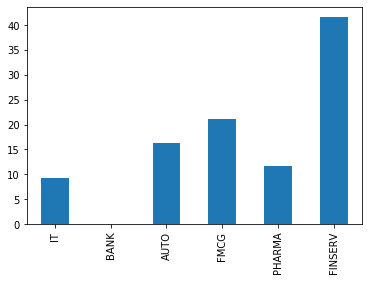

In [45]:
weights.plot.bar()

Even though the allocation percentages don't match, the relative contributions from sectors do roughly align with the actual sector wise allocation for the Mutual Fund as seen on Moneycontrol.com

In reality the sector wise allocation is: BANK > FINSERV > AUTO > IT > PHARMA > FMCG

As per the analysis the sector wise allocation is: FINSERV > FMCG > AUTO > IT > PHARMA > BANK

The one major suprising result is that the BANK NIFTY contribution is nearly zero but the allocation to Financial Services is very high. In reality the allocation to Banks is 14.27% and FinServ is 11.46%, for a total of ~25% makes it appear as if the BANK NIFTY allocation is also being included in FINSERV. 